In [23]:
import pandas as pd
import csv
import numpy as np
import glob
import os
import matplotlib.pyplot as plt

window_time = 700
n_data = 20      # number of data 
n_texture = 9   # number of texture
n_surface = 1   # number of surface for each texture
header = [['Time','Strain_f'],
          ['Time','Strain_b']]
list_texture = ['P40_a','P40_b','P40_c','P60_a','P60_b','P60_c','P80_a','P80_b','P80_c']
list_pressure = [0]
modes = ['forward']
folder = ['test_data_02_28']



### Import strain data:

In [25]:
index = list(range(int(n_texture*n_surface*n_data/2)*window_time))
for mode in modes:
    for pressure in list_pressure:
        strain_data_forward = []
        os.chdir("C:\\Users\\nhnha\\OneDrive\\Desktop\\Whisker paper\\Living-machine2023\\strain_data\\"+folder[0]+"\\"+mode+"\\P = "+str(pressure))
        for filename in list_texture:
            raw_data_forward = []
            for i in range(int(n_data/2)):    # number of data for 1 single texture in forward sweeping direction
                raw_csv_forward = pd.read_csv(filename+'0000_I0'+f"{i*2:03}"+'.CSV',skiprows = 14,
                                                header=None, names=header[0])
                calib_forward = raw_csv_forward['Strain_f'][0]
                for j in range(700):
                    raw_data_forward.append(raw_csv_forward.iloc[250+j])
                    temp_forward = float(raw_data_forward[700 * i + j]['Strain_f']) - calib_forward
                    raw_data_forward[700 * i + j]['Strain_f'] = temp_forward

            strain_data_forward.extend(raw_data_forward)
        strain_data_forward = pd.DataFrame(strain_data_forward,index = index)
        strain_data_forward = strain_data_forward.drop(columns='Time')

        strain_data_backward = []
        for filename in list_texture:
            raw_data_backward = []
            for i in range(int(n_data/2)):    # number of data for 1 single texture in forward sweeping direction
                raw_csv_backward = pd.read_csv(filename+'0000_I0'+f"{i*2+1:03}"+'.CSV',skiprows = 14,
                                                header=None, names=header[1])
                calib_backward = raw_csv_backward['Strain_b'][0]
                for j in range(700):
                    raw_data_backward.append(raw_csv_backward.iloc[250+j])
                    temp_backward = float(raw_data_backward[700 * i + j]['Strain_b']) - calib_backward
                    raw_data_backward[700 * i + j]['Strain_b'] = temp_backward

            strain_data_backward.extend(raw_data_backward)
        strain_data_backward = pd.DataFrame(strain_data_backward,index = index)
        strain_data_backward = strain_data_backward.drop(columns='Time')
strain_data_backward


In [26]:
# Time
time_list = list(range(int(n_data/2)*window_time))
total_time = list(range(len(time_list)*n_surface*n_texture))
for k in range(n_texture):
    for i in range(n_surface):
        for j in range(len(time_list)):
            total_time[j+int(n_data/2)*window_time*i*k]=time_list[j]

strain_data = (strain_data_forward.join(strain_data_backward)).assign(Time = total_time)
strain_data

,Strain_f,Strain_b,Time
0,-100.211429,117.371429,0
1,-100.545714,114.795714,1
2,-100.680000,114.538571,2
3,-101.405714,116.810000,3
4,-98.974286,101.808571,4
...,...,...,...
62995,-98.034286,115.355714,62995
62996,-98.665714,114.168571,62996
62997,-98.177143,113.791429,62997
62998,-97.264286,114.780000,62998


In [45]:
# Fast Fourier Transform (FFT)
def FFT(dataset, plot):
    global dominate_freq
    dt = 1/100     # tần số lấy mẫu = 100Hz
    t = np.arange(0,7,dt)
    n = len(t)
    lowpass_order_filltered = 1
    highpass_order_filltered = 0
    fhat = np.fft.fft(dataset,n)
    mag = np.abs(fhat)/n  # chia cho n =  normalization in the spectral domain 
    PSD = fhat * np.conj(fhat)/n
    L = np.arange(1,np.floor(n/2),dtype='int')
    freq = (1/(dt*n))*np.arange(n) 
    centroid = np.sum(freq[lowpass_order_filltered:(350-highpass_order_filltered)]
                      *mag[lowpass_order_filltered:(350-highpass_order_filltered)])/np.sum(mag[lowpass_order_filltered:(350-highpass_order_filltered)])
    sum_energy = np.sum(mag[lowpass_order_filltered:(len(L)-highpass_order_filltered)])
    weight_mean_amplitude = np.sum(freq[lowpass_order_filltered:(350-highpass_order_filltered)]
                      *mag[lowpass_order_filltered:(350-highpass_order_filltered)])/np.sum(freq[lowpass_order_filltered:(350-highpass_order_filltered)])
    
    max_mag = max(mag[lowpass_order_filltered:-1])   
    for i in range(lowpass_order_filltered, len(freq)): 
        if abs(mag[i] - max_mag) < 0.00000001:
            dominate_freq = freq[i]
            break
    if plot == True:
        plt.close() 
        plt.rcParams['figure.figsize'] = [7,7]
        plt.rcParams.update({'font.size': 12})
        plt.plot(freq[L],mag[L],color='c', linewidth=2)
        # plt.plot([centroid]*len(freq[lowpass_order_filltered:len(L)]),mag[lowpass_order_filltered:len(L)],color='r', linewidth=2)
#         plt.plot(freq[L],[energy]*len(L))
        # plt.text(centroid,0,'Spectral centroid = '+ str(centroid), va = 'top')
        # plt.text(25,max_mag/2,'Sum energy = '+ str(sum_energy), va = 'top')
        plt.text(dominate_freq,max_mag,'dominate frequency = '+ str(dominate_freq), va = 'top')
        plt.xlim(freq[L[0]],freq[L[-1]])
        plt.xlabel('Frequency (Hz)')
        plt.ylabel('Magnitude')
        plt.show()
    
    return dominate_freq, freq, mag, max_mag, centroid, sum_energy, fhat

def freq_filter(dataset, low_cut_freq, high_cut_freq,plot):
    dt = 1/100     # tần số lấy mẫu = 100Hz
    t = np.arange(0,6,dt)
    n = len(t)
    dominate_freq, freq, mag, max_mag, centroid, energy, fhat = FFT(dataset,plot = False)
    indices = np.logical_or(np.logical_and(freq>low_cut_freq, freq<high_cut_freq), 
                            np.logical_and(freq>100-high_cut_freq, freq<100-low_cut_freq))
    indices[0] = True
    L = np.arange(1,np.floor(n/2),dtype='int')
    clean_mag = mag*indices
    fhat = indices * fhat

    ffilt = (np.fft.ifft(fhat)).real
    if plot == True:
        fig, axs = plt.subplots(2,1,sharex=False, sharey=False)
        plt.sca(axs[0])
        plt.plot(t,ffilt,linewidth=2, color='c', label='Filtered')
        plt.plot(np.arange(0,6,dt),dataset, color='r', linewidth=2,label='Raw')
        plt.legend()
        plt.xlabel('Time (s)')
        plt.ylabel('Magnitude')
        
        plt.sca(axs[1])
        plt.plot(freq[L],clean_mag[L],color='c', linewidth=2, label = 'Filtered')
        plt.plot(freq[L],mag[L],color='r', linewidth=2, label = 'Raw')
        plt.xlim(freq[L[0]],freq[L[-1]])
        plt.legend()
        plt.xlabel('Frequency')
        plt.ylabel('Magnitude')
        
        fig.add_subplot(111, frameon = False)
        plt.tick_params(labelcolor='none', top=False, bottom=False, left=False, right=False)
        plt.title('Comparison data in time domain after filtering' )
    return ffilt, clean_mag

In [14]:
from sklearn import preprocessing
sc_maxabs = preprocessing.MaxAbsScaler()
tempo_data =[]
header = ['Strain_f','Strain_b']
sc_maxabs.fit(strain_data[['Strain_f','Strain_b']])
strain_data_scaled = sc_maxabs.transform(strain_data[['Strain_f','Strain_b']])
strain_data_scaled = (pd.DataFrame(strain_data_scaled, columns=header)).assign(Time = total_time)

strain_data_scaled

### No normalization
k = 0
for filename in list_texture:
    for i in range(int(n_data/2)):
        strain_data[700*(10*k+i):700*(10*k+i+1)].to_csv(filename+'_'+f"{i * 2:02}"+'.csv',columns=['Strain_f'], index=0)
        strain_data[700*(10*k+i):700*(10*k+i+1)].to_csv(filename+'_'+f"{i * 2+1:02}"+'.csv',columns=['Strain_b'], index=0)
    k += 1

### With normalization
# k = 0
# for filename in list_texture:
#     for i in range(int(n_data/2)):
#         strain_data_scaled[700*(10*k+i):700*(10*k+i+1)].to_csv(filename+'_'+f"{i * 2:02}"+'_scaled.csv',columns=['Strain_f'], index=0)
#         strain_data_scaled[700*(10*k+i):700*(10*k+i+1)].to_csv(filename+'_'+f"{i * 2+1:02}"+'_scaled.csv',columns=['Strain_b'], index=0)
#     k += 1


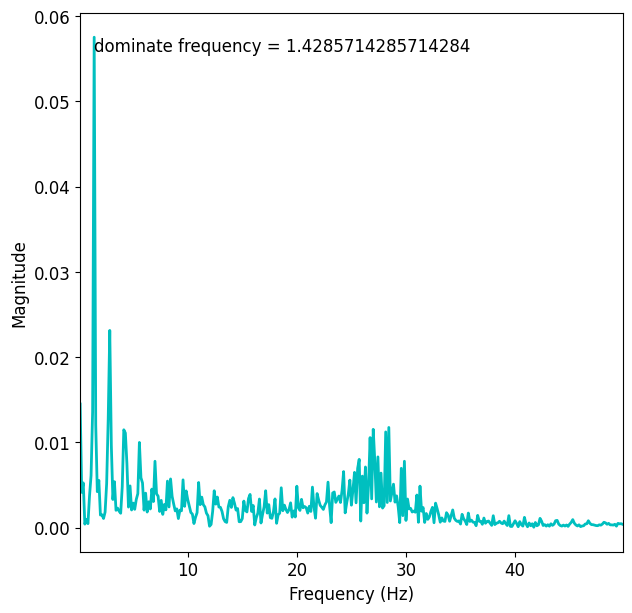

array([7.90911382e-01, 1.45044209e-02, 4.13833419e-03, 5.24776630e-03,
       4.11463832e-04, 9.77820293e-04, 4.67522322e-04, 3.69881231e-03,
       6.11256384e-03, 1.36080911e-02, 5.75386516e-02, 1.20327169e-02,
       4.21627719e-03, 5.54219763e-03, 1.47707048e-03, 1.51381917e-03,
       1.07508200e-03, 1.82167551e-03, 5.17735106e-03, 1.27774623e-02,
       2.31374584e-02, 9.63785584e-03, 3.30108849e-03, 5.39015154e-03,
       2.03444956e-03, 2.28651527e-03, 1.92841283e-03, 1.68514364e-03,
       4.78879782e-03, 1.14782912e-02, 1.11031608e-02, 7.50668108e-03,
       2.40878870e-03, 4.89468100e-03, 2.07012968e-03, 2.87674124e-03,
       2.14778495e-03, 3.30969249e-03, 3.98718362e-03, 9.99336414e-03,
       5.85743616e-03, 5.23409228e-03, 2.05212749e-03, 4.04363021e-03,
       1.82943549e-03, 3.03283735e-03, 2.18726242e-03, 4.51894235e-03,
       3.05849157e-03, 7.78393902e-03, 3.96472847e-03, 3.68699708e-03,
       1.89577249e-03, 3.19759447e-03, 1.55450155e-03, 2.71078600e-03,
      

In [55]:
dominate_freq, freq, mag, max_mag, centroid, energy, fhat = FFT(strain_data_scaled[header[0]][0:700],plot = 1)
freq
mag

In [ ]:
data = []

for m in header:
    tempo_data =[]
    for i in range(n_texture):
        for j in range(n_surface):
            for k in range(int(n_data/2)): 
                index = range(window_time*(int(n_data*n_surface*i/2)+int(n_data*j/2)+k),window_time*(int(n_data*n_surface*i/2)+int(n_data*j/2)+k+1))
                tempo_data.extend((freq_filter(strain_data_scaled[m][index],0.66666667,10, plot=0))[0])
    data  = data + [tempo_data]

processed_data = []
for i in range(len(data[0])):
    post_strain_data = []
    for j in range(len(header)):
        post_strain_data.append(data[j][i]) 
    processed_data.extend([post_strain_data])
processed_strain_data = (pd.DataFrame(processed_data, columns=header)).assign(Time = total_time)